# Viz Code

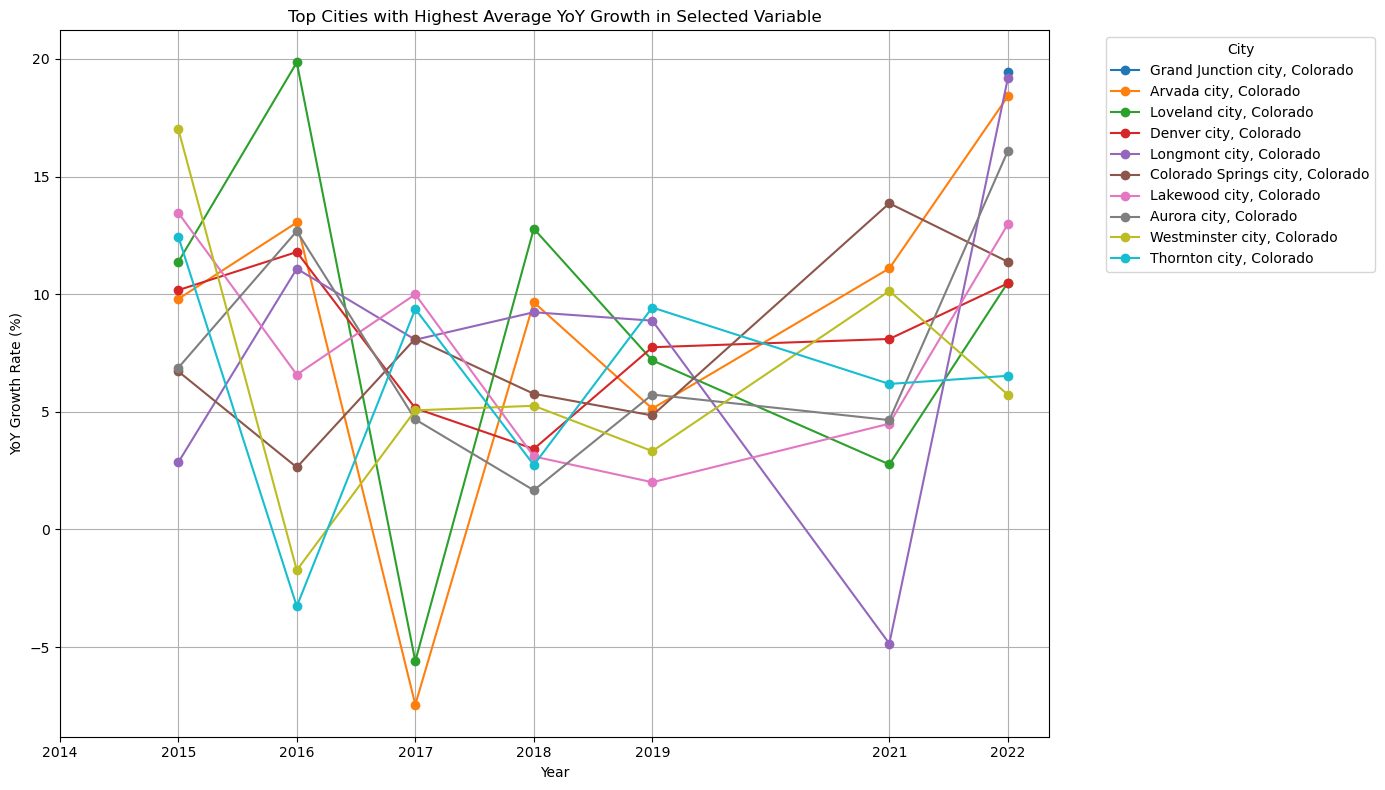

In [1]:
# For PowerBI: The following code to create a dataframe and remove duplicated rows is always executed and acts as a preamble for your script: 

# dataset = pandas.DataFrame(FIPS Code)
# dataset = dataset.drop_duplicates()

# Paste or type your script code here:

import requests
import pandas as pd
import matplotlib.pyplot as plt

# read api keys file
df = pd.read_csv('/Users/troys/OneDrive/Documents/Python/BeeEye/api_keys.csv')

# Constants
API_KEY = df.loc[df['API'] == 'census']['KEY'].iloc[0]
BASE_URL = 'https://api.census.gov/data'
YEARS = [2022, 2021, 2019, 2018, 2017, 2016, 2015, 2014]  # Example years, adjust as needed
#VARIABLE = dataset['Variable'].iloc[0] # For Power BI
VARIABLE = 'B25064_001E'  # Median gross rent (check variable name for each year if necessary)
# STATE = f"{dataset['FIPS Code'].iloc[0]:02}" # For Power BI
STATE = '08'

def get_rental_data(year):
    url = f'{BASE_URL}/{year}/acs/acs1?get=NAME,{VARIABLE}&for=place:*&in=state:{STATE}&key={API_KEY}'  # Filtering for Colorado
    response = requests.get(url)
    if response.status_code == 200:
        data = response.json()
        # Ensure the column is immediately renamed upon DataFrame creation
        df = pd.DataFrame(data[1:], columns=data[0])
        df.rename(columns={VARIABLE: 'Selected_Variable'}, inplace=True)  # Renaming here
        df['Year'] = year
        return df
    else:
        print(f'Failed to retrieve data for {year}')
        return pd.DataFrame()

# Fetch data for each year and combine into a single DataFrame, focusing on Colorado
all_data = pd.concat([get_rental_data(year) for year in YEARS], ignore_index=True)

# Ensure the 'Year' and 'Median_Rental_Price' columns are of the correct data type
all_data['Year'] = all_data['Year'].astype(int)
all_data['Selected_Variable'] = all_data['Selected_Variable'].astype(float)

# Now, 'Median_Rental_Price' should exist as a column. Proceed with YoY Growth calculation
all_data.sort_values(by=['NAME', 'Year'], inplace=True)
all_data['YoY_Growth'] = all_data.groupby('NAME')['Selected_Variable'].pct_change() * 100

# Pivot the data for easier analysis
pivot_data = all_data.pivot(index='NAME', columns='Year', values='YoY_Growth')

# Calculate average YoY growth for each city
pivot_data['Avg_YoY_Growth'] = pivot_data.mean(axis=1)

# Identify top cities with the highest average YoY growth
top_cities = pivot_data.sort_values(by='Avg_YoY_Growth', ascending=False).head(10)

# Plotting
plt.figure(figsize=(14, 8))
years_for_plotting = sorted(YEARS)

for city in top_cities.index:
    growth_rates = top_cities.loc[city, years_for_plotting].values
    plt.plot(years_for_plotting, growth_rates, marker='o', linestyle='-', label=city)

plt.title('Top Cities with Highest Average YoY Growth in Selected Variable')
plt.xlabel('Year')
plt.ylabel('YoY Growth Rate (%)')
plt.xticks(years_for_plotting)
plt.legend(title='City', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(True)
plt.tight_layout()
plt.show()

# Variable Dataset Code

In [2]:
import requests
import pandas as pd

# Define the URL for the ACS 5-Year Estimates variables for 2022
variables_url = 'https://api.census.gov/data/2022/acs/acs5/variables.json'

# Make the request to get the variables JSON from the U.S. Census API
response = requests.get(variables_url)

# Check if the request was successful
if response.status_code == 200:
    variables_data = response.json()
    
    # Convert the 'variables' part of the JSON response into a pandas DataFrame
    variables_df = pd.DataFrame.from_dict(variables_data['variables'], orient='index')
    
    # Reset the index to turn the variable names into a column
    variables_df.reset_index(inplace=True)
    variables_df.rename(columns={'index': 'Variable'}, inplace=True)
    
    # Optionally, select specific columns to display in Power BI, if you don't need the whole dataset
    # For example, to keep only the 'Variable', 'label', and 'concept' columns, you could do:
    # variables_df = variables_df[['Variable', 'label', 'concept']]
    
else:
    # If the request was not successful, create an empty DataFrame with a similar structure
    # This ensures that Power BI has a DataFrame to load, even if it's empty
    variables_df = pd.DataFrame(columns=['Variable', 'label', 'concept'])
    print(f"Failed to fetch variables. Status Code: {response.status_code}")

# Output the DataFrame
# This is the DataFrame that Power BI will use as a data source
variables_df


,Variable,label,concept,predicateType,group,limit,predicateOnly,hasGeoCollectionSupport,attributes,required
0,for,Census API FIPS 'for' clause,Census API Geography Specification,fips-for,N/A,0,True,NaN,NaN,NaN
1,in,Census API FIPS 'in' clause,Census API Geography Specification,fips-in,N/A,0,True,NaN,NaN,NaN
2,ucgid,Uniform Census Geography Identifier clause,Census API Geography Specification,ucgid,N/A,0,True,True,NaN,NaN
3,B24022_060E,Estimate!!Total:!!Female:!!Service occupations...,Sex by Occupation and Median Earnings in the P...,int,B24022,0,NaN,NaN,"B24022_060EA,B24022_060M,B24022_060MA",NaN
4,B19001B_014E,"Estimate!!Total:!!$100,000 to $124,999",Household Income in the Past 12 Months (in 202...,int,B19001B,0,NaN,NaN,"B19001B_014EA,B19001B_014M,B19001B_014MA",NaN
...,...,...,...,...,...,...,...,...,...,...
28188,B25124_022E,Estimate!!Total:!!Owner occupied:!!3-person ho...,Tenure by Household Size by Units in Structure,int,B25124,0,NaN,NaN,"B25124_022EA,B25124_022M,B25124_022MA",NaN
28189,B20005I_071E,"Estimate!!Total:!!Female:!!Worked full-time, y...",Sex by Work Experience in the Past 12 Months b...,int,B20005I,0,NaN,NaN,"B20005I_071EA,B20005I_071M,B20005I_071MA",NaN
28190,B08113_054E,Estimate!!Total:!!Worked from home:!!Speak oth...,Means of Transportation to Work by Language Sp...,int,B08113,0,NaN,NaN,"B08113_054EA,B08113_054M,B08113_054MA",NaN
28191,B06009_006E,Estimate!!Total:!!Graduate or professional degree,Place of Birth by Educational Attainment in th...,int,B06009,0,NaN,NaN,"B06009_006EA,B06009_006M,B06009_006MA",NaN
